In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.path import Path
import yaml

In [2]:
with open("panel_0.yaml") as f:
    config = yaml.safe_load(f)

In [3]:
geoms = np.array(config["detector"]["detector geometry"])

In [4]:
from typing import TypedDict

Transform = TypedDict(
    'Transform', 
    {
        'angle': float, 
        'trans_r': float,
        'trans_t': float
    }
)

def transform_verts(verts: np.ndarray, trans: Transform)->np.ndarray:
    angle = np.deg2rad(trans['angle'])
    trans_r = trans['trans_r']
    trans_t = trans['trans_t']
    mtrans = np.array(
        [
            [np.cos(angle),-np.sin(angle)],
            [np.sin(angle),np.cos(angle)]
        ]
    )
    return np.array(
        [np.matmul(
            mtrans,
            vert+np.array([trans_r,trans_t])) for vert in verts
        ])
    
    
def geom2verts(geom:np.ndarray,trans: Transform)->np.ndarray:
    verts = np.array(
        [[geom[0],geom[2]],
         [geom[1],geom[2]],
         [geom[1],geom[3]],
         [geom[0],geom[3]],
         [geom[0],geom[2]]
        ])
    return transform_verts(verts, trans)

def verts_to_patch(verts:np.ndarray)->PatchCollection:
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts, codes)
    return patches.PathPatch(path, facecolor='orange', ec='none')

def geoms_to_patchcollection(
    geoms:np.ndarray,
    trans_list: list[Transform],
    fc:str='orange',
    ec:str='none'
)->matplotlib.patches.PathPatch:
    verts_list = []
    for trans in trans_list:
        for geom in geoms:
            verts_list.append(
                geom2verts(geom, trans)
            )
    return PatchCollection(
        [verts_to_patch(verts) for verts in verts_list],
        fc=fc,ec=ec
    )
        

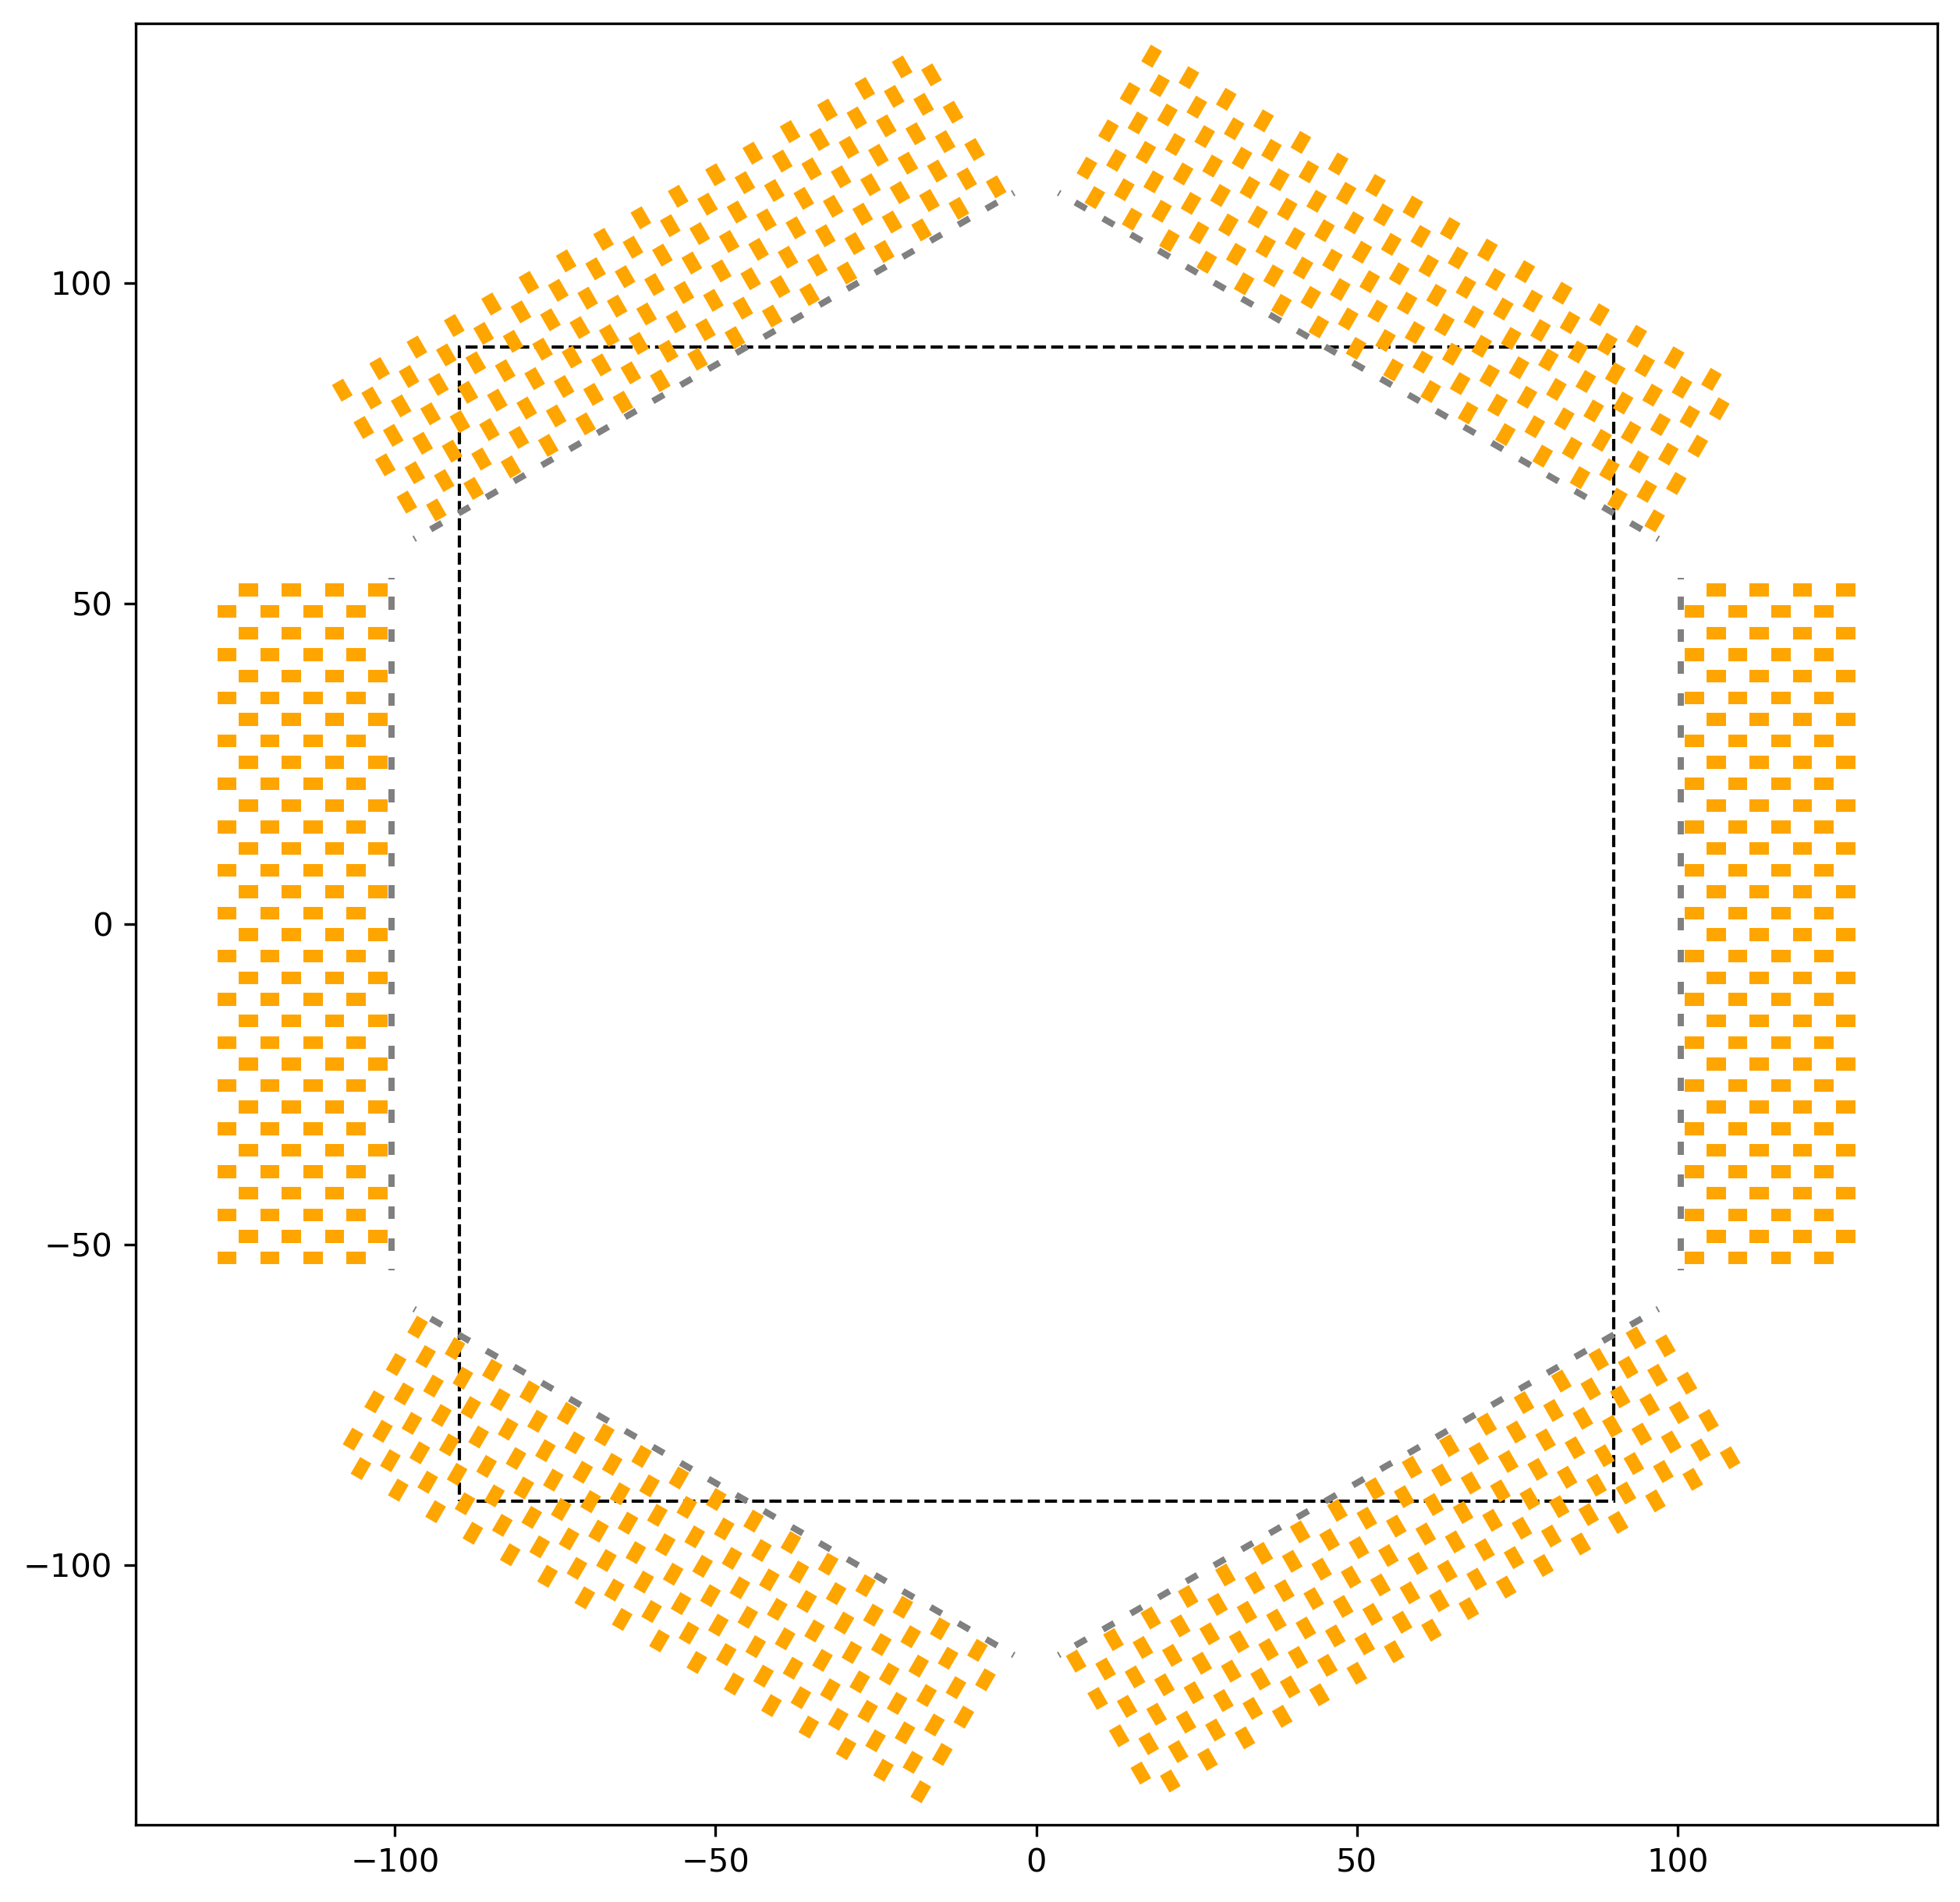

In [10]:
fov_dims = np.array(config["FOV"]["N voxels xyz"]) * np.array(
    config["FOV"]["mm per voxel xyz"]
)
trans_t = -(np.max(geoms[:, 3]) + np.min(geoms[:, 2])) / 2
det_dims = np.array(
    [
        np.max(geoms[:, 1]) - np.min(geoms[:, 0]),
        np.max(geoms[:, 3]) - np.min(geoms[:, 2]),
        np.max(geoms[:, 5]) - np.min(geoms[:, 4]),
    ]
)

trans_r = config["relation"]["radial shift"]["data"][0]
trans_list = [{"angle": angle, "trans_r": trans_r, "trans_t": trans_t} for angle in range(0, 360, 60)]

# patch = verts2rect(transform_verts(verts,trans))
active_det_geoms = geoms[geoms[:, 6] != 0]
plate_geoms = geoms[geoms[:, 6] == 0]

det_coll = geoms_to_patchcollection(active_det_geoms, trans_list)
plate_coll = geoms_to_patchcollection(plate_geoms, trans_list, fc="gray")

coll = geoms_to_patchcollection(geoms, trans_list)
fig, ax = plt.subplots(figsize=(11, 10), dpi=300)
ax.add_patch(plt.Rectangle(-fov_dims // 2, fov_dims[0], fov_dims[1], fc="none", ec="k",ls='--'))
ax.add_collection(det_coll)
ax.add_collection(plate_coll)
# ax.add_collection(coll)
ax.set_xlim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
ax.set_ylim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
ax.set_aspect("equal")
plt.show()
fig.savefig("panel_0.png")
del fig, ax, det_coll, plate_coll, coll

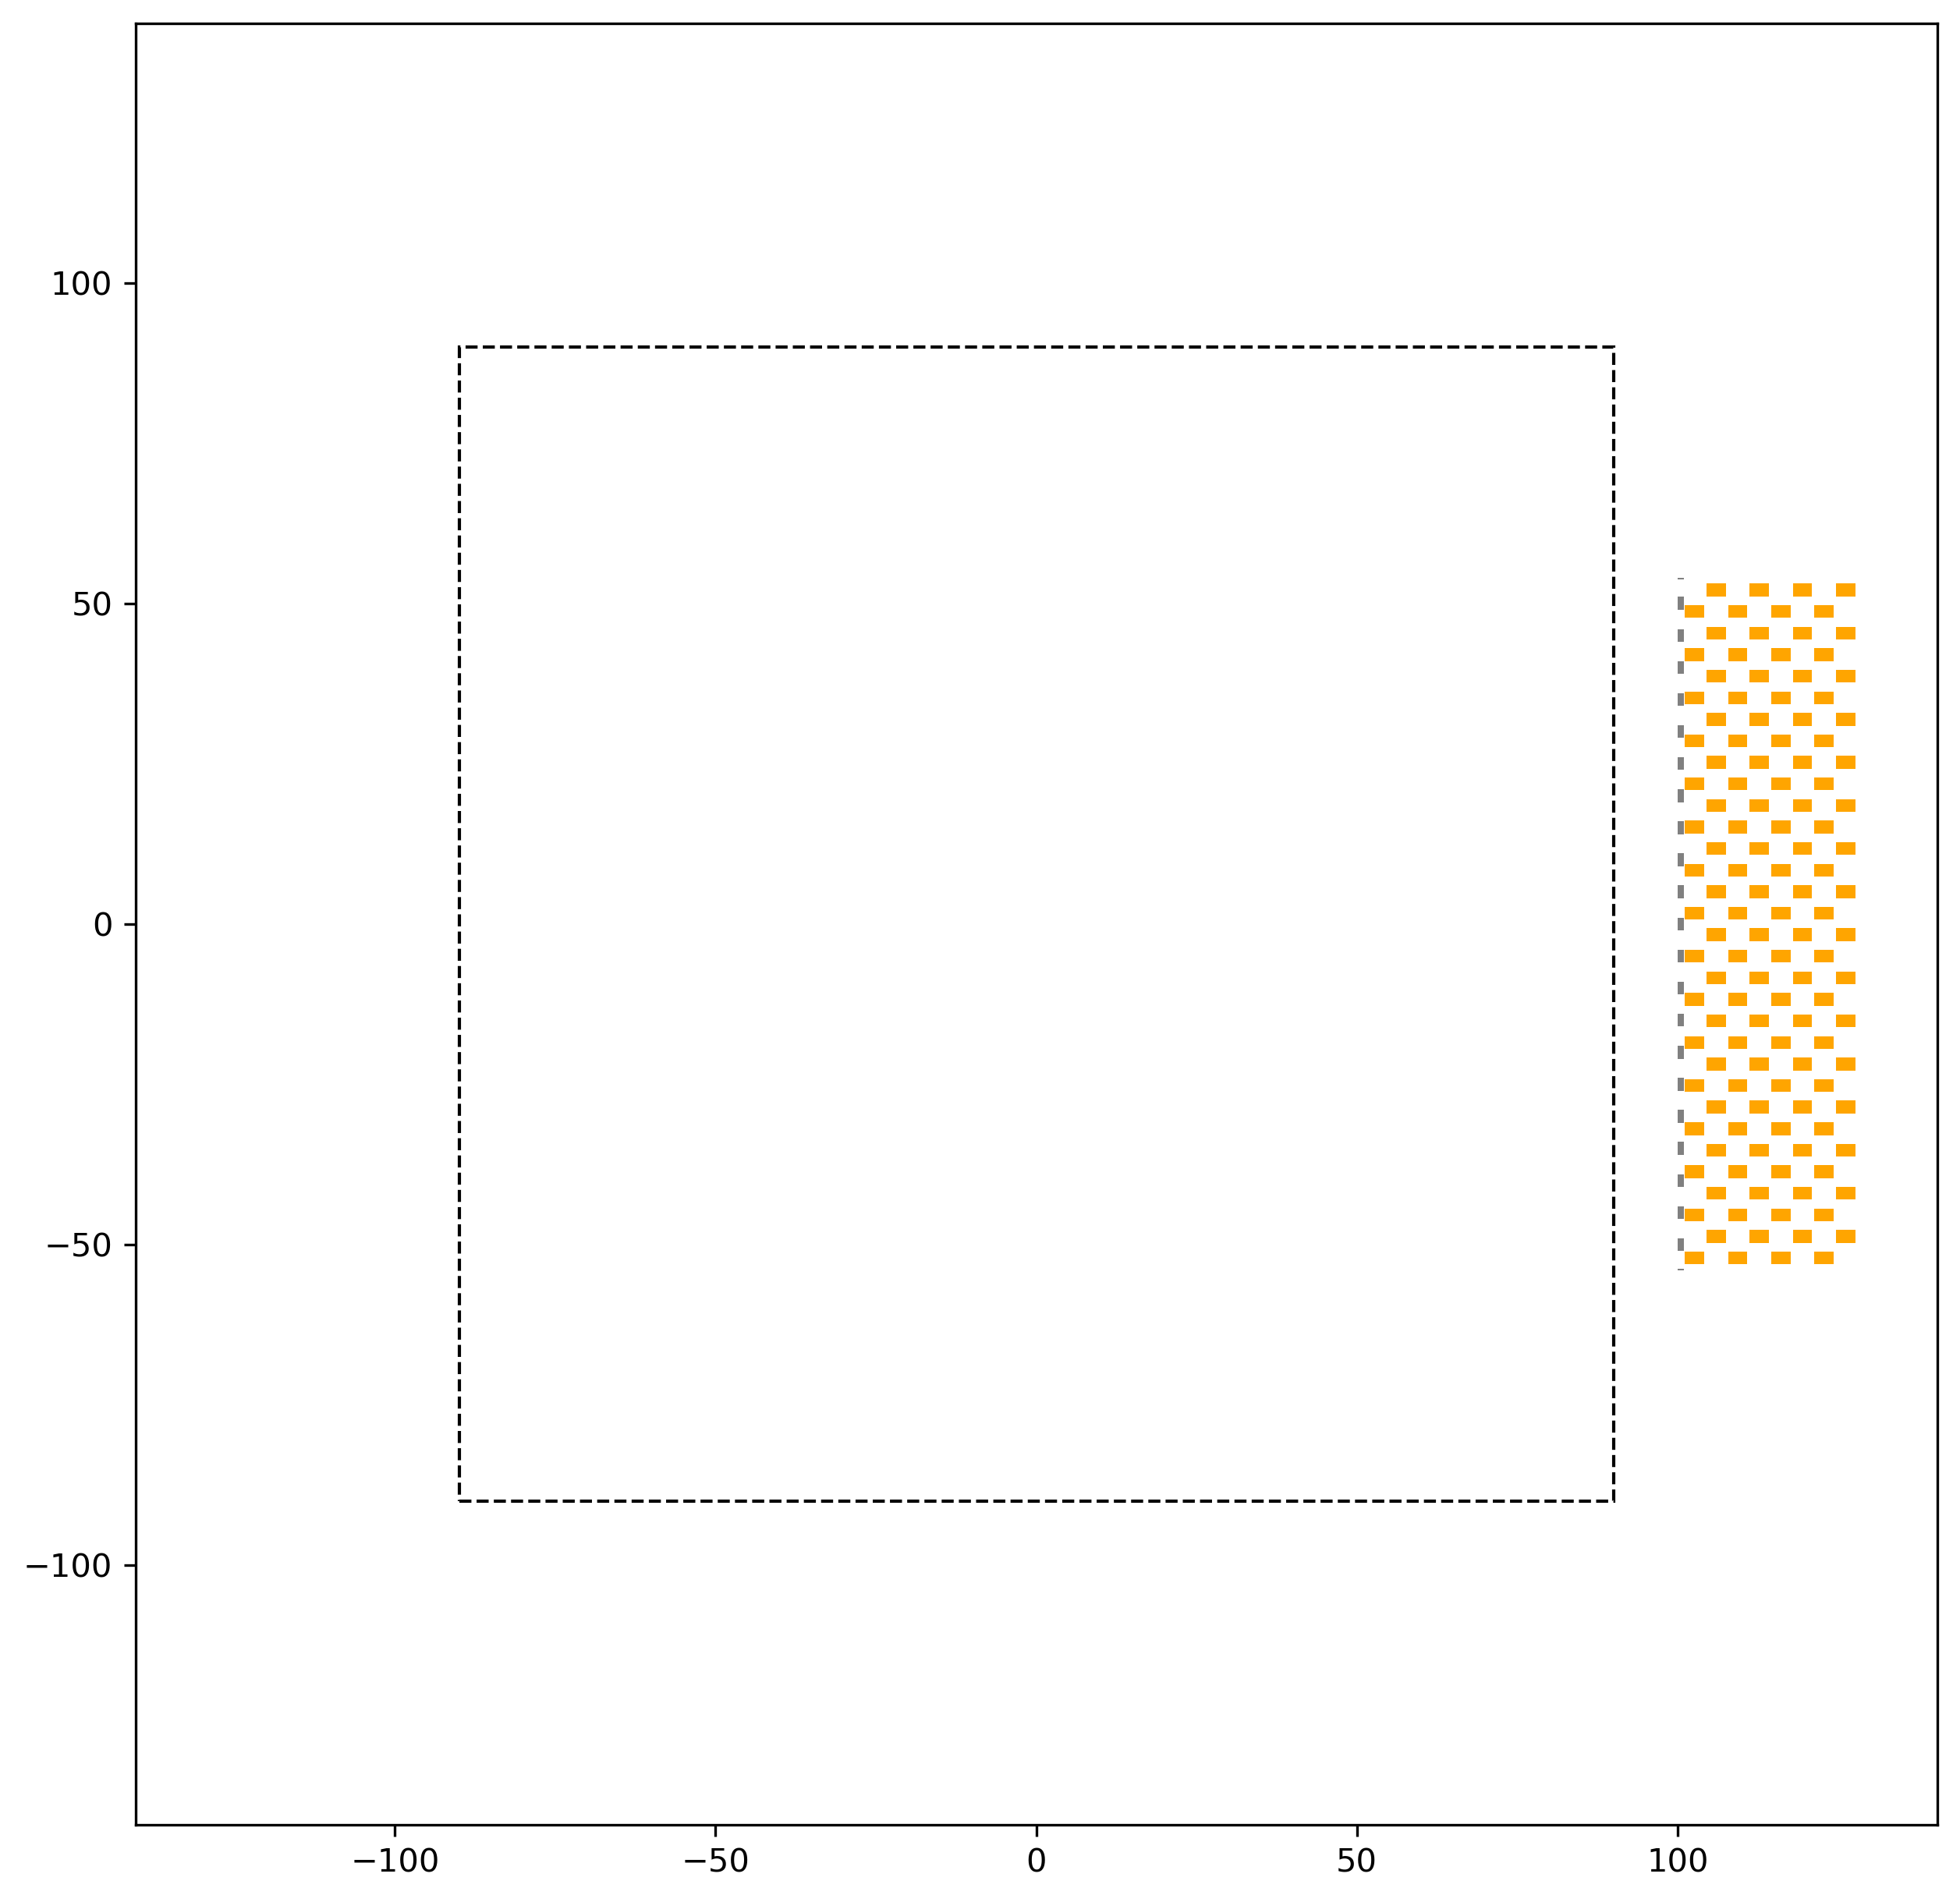

In [13]:
for i in range(0, 1):
    with open(f"panel_{i}.yaml") as f:
        config = yaml.safe_load(f)
        fov_dims = np.array(config["FOV"]["N voxels xyz"]) * np.array(
            config["FOV"]["mm per voxel xyz"]
        )
        geoms = np.array(config["detector"]["detector geometry"])

        trans_t = -(np.max(geoms[:, 3]) + np.min(geoms[:, 2])) / 2
        det_dims = np.array(
            [
                np.max(geoms[:, 1]) - np.min(geoms[:, 0]),
                np.max(geoms[:, 3]) - np.min(geoms[:, 2]),
                np.max(geoms[:, 5]) - np.min(geoms[:, 4]),
            ]
        )

        trans_r = config["relation"]["radial shift"]["data"][0]
        trans_list = [
            {"angle": config["relation"]["rotation"]["data"][0], "trans_r": trans_r, "trans_t": trans_t}
        ]

        # patch = verts2rect(transform_verts(verts,trans))
        active_det_geoms = geoms[geoms[:, 6] != 0]
        plate_geoms = geoms[geoms[:, 6] == 0]

        det_coll = geoms_to_patchcollection(active_det_geoms, trans_list)
        plate_coll = geoms_to_patchcollection(plate_geoms, trans_list, fc="gray")

        coll = geoms_to_patchcollection(geoms, trans_list)
        fig, ax = plt.subplots(figsize=(11, 10), dpi=300)
        ax.add_patch(
            plt.Rectangle(
                -fov_dims // 2, fov_dims[0], fov_dims[1], fc="none", ec="k", ls="--"
            )
        )
        ax.add_collection(det_coll)
        ax.add_collection(plate_coll)
        # ax.add_collection(coll)
        ax.set_xlim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
        ax.set_ylim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
        ax.set_aspect("equal")
        plt.show()
        fig.savefig(f"panel_{i}.png")
        del fig, ax, det_coll, plate_coll, coll